In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import yfinance.shared as shared
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures 
import random

## Group Assignment
### Team Number: 4
### Team Member Names: Cloris, James, Cherry
### Team Strategy Chosen: SAFE

## Introduction
Our team chose to build a safe portfolio, which means we wanted the total portfolio value to experience very minimal change from the starting value of 500,000 dollars between the start date and the end date. Since the maximum number of stocks we are allowed to include in our portfolio is 25, we chose to have the maximum number of stocks allowed in our portfolio. This was because we want to have our portfolio as diversified as possible, in order to mitigate non-systematic risk such as business risk, financial risk and default risk. Through diversification, investors are able to reduce the non-market risk, but they are unable to reduce the systematic risk. This means having an inter-industry portfolio with the least correlated stocks from different industries. This is to neutralize the negative performance of an individual stock on the total portfolio value. Additionally, by having a diversified portfolio, the effect of business risk within one industry is minimized by the better performing investments in other industries. For instance, stricter policies or higher taxes on businesses within the financial industry, would not affect companies in the healthcare industry as there is no correlation between the two. 

However, if the csv file provided contains less than 25 tickers, then we will include all of them in our portfolio and decide the weightings based on our correlation calculations that are discussed further in step 6. In order to generate the safest portfolio, we took historical data from November 1st, 2018 to November 24th, 2022. We chose a starting date before COVID-19 to gain an accurate representation of the overall trend of each stock as during 2020, as almost all stocks in different industries experienced large fluctuations.  Through various measures of portfolio risk, we were able to generate a portfolio with the maximum number of stocks and their optimal weightings.  


## Our Strategy
In order to pick 25 stocks to build our safe portfolio, we want to be able to quantify and measure the risk of our total portfolio to ensure it is as safe as possible. The three measures we used are beta, which is a measurement of systematic risk, standard deviation, which is a measurement of the total risk of our portfolio’s expected return, and correlation, which is a measurement of how closely the returns of each security are related to each other. 

The following is a summary of the strategy we implemented: 
1. Filter the Stocks
2. Calculate Beta
3. Calculate Standard Deviation
4. Rankings
5. Calculate Correlation
6. Portfolio Weightings
7. Generate Final Portfolio

Each step of our strategy explains more in depth on how each measure is used to create a safe portfolio.


### Step 1: Filter the Stocks 
Before building our portfolio, we had to filter the given tickers from the provided csv file based on the guidelines of this assignment. We first removed any duplicated tickers and filtered out any delisted stocks from the list. Next, we removed any tickers that did not reference a valid stock denominated in USD by checking the currency of each stock. The function “get_data” is able to do so for us by consuming the original ticker list and producing a new ticker list without duplicate tickers or delisted tickers. After this, we removed any stocks that had an average monthly volume less than 200,000 shares, as calculated based on the given time interval of January 1st, 2022 to October 31st, 2022 and dropped any month that does not have at least 20 trading days. The function “filter_volume_currency” helps us filter our list of tickers based on the conditions mentioned above. 


In [2]:
#get ticker from csv file
tickers = pd.read_csv('Tickers.csv', header=None) 
tickers.columns = ['ticker']

#set start and end date
start_date = '2018-11-01'
end_date = '2022-11-24'
#create the range for dates
dates = pd.date_range(start_date, end_date)


In [3]:
#Remove Duplicate Tickers 
# https://www.w3schools.com/python/python_howto_remove_duplicates.asp
no_duplicate_tickers = list(dict.fromkeys(tickers['ticker']))


In [4]:
#get_data consumes the original ticker list produces a new list where the delisted stocks are filtered out
def get_data (ticker_list):
    filter_list = []
    no_error = []
    #get data from yfinance
    data = yf.download(ticker_list, start=start_date, end=end_date)
    #find stocks that have errors or delisted
    errors= list(shared._ERRORS.keys())
    #find tickers that does not have errors
    for ticker in ticker_list:
        if ticker not in errors:
            no_error.append(ticker)
    #create the new list using append, so the list stands by itself
    for t in no_error:
        filter_list.append(t)
    return filter_list

#get a filtered list called filer_list
no_delisted_list=get_data(no_duplicate_tickers)

#to check no_delisted_list -> uncomment
#no_delisted_list

[*********************100%***********************]  35 of 35 completed

3 Failed downloads:
- CELG: No data found, symbol may be delisted
- INVALIDTIC: No data found, symbol may be delisted
- ASDFA: No data found, symbol may be delisted


In [42]:
# NEW CODE

#consumes a semi-filtered listed and further filter it with currency
def filter_currency(ticker):
    #set j to count the list
    company=yf.Ticker(ticker)
    company_info=company.info
    try: 
        if company_info['currency'] != 'USD':
            print(ticker + " was removed because it is not in USD")
            return ticker
        elif company_info['financialCurrency'] != 'USD':
            print(ticker + " was removed because it is not in USD")
            return ticker
        elif company_info['market'] != 'us_market':
            print(ticker+ " was removed because it is not in the US Market")
            return ticker
        return 'N/A'
    except:
        print(ticker + " may not have enough information")
        return ticker

#Creating list for valid filters
invalid = []

# Use threading to filter our ticker_list
with concurrent.futures.ThreadPoolExecutor() as executor:
    
    #Applying stock_filter on every element of ticker_list
    results = executor.map(filter_currency, no_delisted_list)
    
    #Adding the results to the valid_list
    for result in results:
        invalid.append(result)



In [6]:
#use for loop to remove all values that are invalid in the no_delisted_list
i=0
for ticker in no_delisted_list:
    for invalid_stock in invalid:
        if ticker == invalid_stock:
            no_delisted_list.pop(i)
    i=i+1
    
no_delisted_list

['ACRV',
 'AAPL',
 'ABBV',
 'LOW',
 'HOOD',
 'AMZN',
 'AXP',
 'BAC',
 'BMBL',
 'BK',
 'SQ',
 'VZ',
 'CMCSA',
 'SHOP',
 'COST',
 'CSCO',
 'CVS',
 'GM',
 'GOOG',
 'JPM',
 'IBM',
 'ORCL',
 'OXY',
 'DUOL',
 'PEP',
 'SLB',
 'SO',
 'SPG']

In [43]:
# NEW CODE

#threshold_volume for monthly average
threshold_volume = 200000

#temporary start and end for checking volume
temp_start = '2022-01-01'
temp_end = '2022-10-31'


#consumes a semi-filtered listed and further filter it with volume 
def filter_volume(ticker):
    try:
        #set j to count the list
        company=yf.Ticker(ticker)
        company_info=company.info
        stock = company.history(start = temp_start, end=temp_end)
        df_stock = pd.DataFrame({'Volume':stock.Volume})
        df_stock.reset_index(inplace=True)

        #group into dataframes by month
        g = df_stock.groupby(pd.Grouper(key='Date', freq='M'))
        # groups to a list of dataframes 
        dfs = [group for _,group in g]

        monthlyVolume = []
        for i in range (len(dfs)-1):
            if ((len(dfs[i]))< 20):
                dfs.pop(i)
        for k in range (len(dfs)):
            monthlyVolume.append(dfs[k]['Volume'].sum())

        if np.mean(monthlyVolume) < threshold_volume:
            print(ticker + " was removed because it's volume does not meet the threshold")
            return ticker
        return 'N/A'
    except:
        print(ticker + " was removed because does not have appropriate information")
        return ticker

#Creating list for valid filters
invalid = []

# Use threading to filter our ticker_list
with concurrent.futures.ThreadPoolExecutor() as executor:
    
    #Applying stock_filter on every element of ticker_list
    results = executor.map(filter_volume, no_delisted_list)
    
    #Adding the results to the valid_list
    for result in results:
        invalid.append(result)



In [8]:
#use for loop to remove all values that are invalid in the no_delisted_list
i=0
for ticker in no_delisted_list:
    for invalid_stock in invalid:
        if ticker == invalid_stock:
            no_delisted_list.pop(i)
    i=i+1

In [11]:
fully_filtered_list=no_delisted_list

### Here is the fully filtered list displayed:


In [12]:
print('List includes tickers: ')
fully_filtered_list

List includes tickers: 


['AAPL',
 'ABBV',
 'LOW',
 'HOOD',
 'AMZN',
 'AXP',
 'BAC',
 'BMBL',
 'BK',
 'SQ',
 'VZ',
 'CMCSA',
 'SHOP',
 'COST',
 'CSCO',
 'CVS',
 'GM',
 'GOOG',
 'JPM',
 'IBM',
 'ORCL',
 'OXY',
 'DUOL',
 'PEP',
 'SLB',
 'SO',
 'SPG']

### Step 2: Calculate Beta
By definition, beta is used to measure how volatile a particular security is in comparison to the market overall. Typically, the S&P 500 is used as the benchmark for the market as a whole and is given a beta of 1.0. This means that a beta value greater than 1.0 (higher beta) would indicate a riskier security, so its returns would be more volatile compared to the market returns. If a security has a beta of 1.25, this would generally suggest that the security’s returns are 125% more volatile than the market returns. On the contrary, a beta value less than 1.0 (low beta) would indicate a safer security, so its returns would be less volatile compared to the market returns. If a security has a beta of 0.5, this would generally suggest that the security’s returns are 50% as volatile as the market returns. 

Beta can be calculated with the following formula:
\begin{align*}
\beta=\frac{COV(x_i,r_M)}{\sigma^2(r_M)}
\end{align*}


With this in mind, using the newly filtered list of tickers, we calculated the absolute value of the beta values for each stock based on their weekly returns with the function “find_beta” that produces a sorted dataframe of all the stocks’ beta values in ascending order. In our case, when we compared the beta of each stock with the market, we wanted to find the stocks with the **lowest beta values** (as close to 0 as possible). As mentioned above, securities with a low beta value close to 0 would indicate a safer security, so its returns would be less volatile compared to the market returns. In other words, the price of the security does not fluctuate as much and there is less risk involved, which in turn would contribute to creating a safe portfolio. 



In [13]:
# find_beta_helper(stockname, market) consumes a stock name and the market index, and then produce the beta value of the
# stock to the market

def find_beta_helper(stockname, market):
    
    # initial setting of the stock, market index and the time frame
    Stock = yf.Ticker(stockname)
    MarketIndex = yf.Ticker(market)
    
    # store the historicla price of the stock and market index
    Stock_hist = Stock.history(start=start_date, end=end_date)
    MarketIndex_hist = MarketIndex.history(start=start_date, end=end_date)
    
    # configure the dataframe
    prices = pd.DataFrame()
    prices[Stock] = Stock_hist['Close']
    prices[MarketIndex] = MarketIndex_hist['Close']
    
    # modify the historical stock prices of the dataframe
    weekly_returns=prices.resample('W').ffill().pct_change()
    weekly_returns.drop(index = weekly_returns.index[0], inplace=True)
    
    #calculate the market variance (you will need to reference the column correponding to the market)
    MarketVar=weekly_returns[MarketIndex].var()

    #calculate beta by taking a covariance (.cov()), and using MarketrVar that was just defined.
    Beta=abs(weekly_returns.cov()/MarketVar)
    
    return Beta.iat[0,1]

In [14]:
# find_beta(ticker_df) consumes a dataframe of all the tickers and produce a sorted dataframe of all the stocks from
# the lowerst to highest beta vlaue

def find_beta(ticker_df):
    ticker_df['beta'] = ''
    for i in ticker_df.index:
        ticker_df.loc[ticker_df['index']==i,'beta'] = find_beta_helper(ticker_df[ticker_df['index'] == i]['ticker'].item(), '^GSPC')
    return ticker_df

### Step 3: Calculate Standard Deviation
By definition, standard deviation, when determining risk, is used to measure how dispersed the expected returns are for a security. The further apart the prices are from its mean price for a particular stock, the higher the standard deviation is. In other words, the wider the distribution of prices, the riskier that particular stock is because it is less predictable and has a greater tendency to experience large fluctuations. 

Standard deviation can be calculated with the following formula:
\begin{align*}
\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
\end{align*}

With this in mind, using the newly filtered list of tickers, we calculated the standard deviation for each stock based on their weekly returns with the function “find_std” that produces a sorted dataframe of all the stocks’ beta values and std values in ascending order. 
In our case, we wanted to find the stocks with the **lowest standard deviation** (as close to 0 as possible). As mentioned above, securities with a low standard deviation close to 0 would indicate a safer security, so the price does not fluctuate as much and there is less risk involved, which in turn would contribute to creating a safe portfolio, where there is minimal change to the total portfolio value over the 5 days. 



In [15]:
# data_storage(stock_name) consumes a stock name and produces the weekly stock price within given time frame
def data_storage(stock_name):
    data_all = pd.DataFrame({}) 
    data_all[stock_name] = yf.Ticker(stock_name).history(start=start_date, end=end_date, interval = "1wk") ['Close']
    data_all.reset_index(inplace=True)
    data_all.dropna()
    return data_all

In [16]:
# stock_worth_return(stock) consumes a stock and then produces the std of the stock's weekly return
def stock_worth_return(stock):
    
    # create a new dataframe for calculation
    dataframe = data_storage(stock)
    stock_worth = pd.DataFrame({}) 
    stock_worth['Date'] = dataframe['Date']
    temp=0
    
    # find the weekly percentage change of the sotck within the time period
    for k in stock_worth.Date:
        month_sum = 0
        month_sum = dataframe[dataframe['Date'] == k][stock].item()
        stock_worth.loc[stock_worth['Date'] == k, stock] = month_sum
        if (temp == 0):
            stock_worth.loc[stock_worth['Date'] == k, stock + ' % return'] = 1
        else:
            stock_worth.loc[stock_worth['Date'] == k, stock + ' % return'] = month_sum / temp 
        temp = month_sum
    
    # calculate the std value of the stock based on the dataframe of its historical price
    stdvalue = stock_worth[stock + ' % return'].std()
    
    return stdvalue

In [17]:
# find_std(ticker_df) consumes a dataframe of tickers and produces combines dataframe that contains index, ticker, 
# beta value and std value
def find_std(ticker_df):
    ticker_df['std'] = ''
    for i in ticker_df.index:
        ticker_df.loc[ticker_df['index']==i,'std'] = stock_worth_return(ticker_df[ticker_df['index'] == i]['ticker'].item())
    return ticker_df


### Step 4: Rankings
The next step in our strategy was to rank the tickers based on their beta value and standard deviation using the function “ranking“. After ranking them, the sum of their beta rank and standard deviation rank was taken and put into another column called “sum ranking”. From there, the tickers were ranked again and sorted in ascending order in the dataframe called “ranked_stats”. The final rankings can be found in the last column called “final ranking” and the top 25 tickers were chosen from the dataframe. 


In [18]:
# create a function that consumes a dataframe of tickers, std value and beta value. Then it produces the 
# ranking of std, beta and overall
def ranking(ticker_df):
    
    ticker_df['std ranking'] = ticker_df['std'].rank(method='max')
    ticker_df['beta ranking'] = ticker_df['beta'].rank(method='max')
    ticker_df['sum ranking'] = ticker_df['std ranking'] + ticker_df['beta ranking']
    ticker_df['final ranking'] = ticker_df['sum ranking'].rank(method='max')
          
    return ticker_df
    

### Generating data: beta, std and correlation is calculated
using the functions explained above, we now find the appropriate statistics for each ticker

we find the beta, std and ranking in this code block


In [19]:
#might take around 3 minutes to run

# store the list into a dataframe
tickerSearch = pd.DataFrame({'ticker':fully_filtered_list})
tickerSearch.reset_index(inplace=True)

# calculate the beta value of the dataframe and store the values into the dataframe
ticker_stats=find_beta(tickerSearch)

# create a new dataframe that has a column for the std value of each stock
ticker_stats=find_std(tickerSearch)

# create a new dataframe that ranks the std, beta and overall
ranked_stats=ranking(ticker_stats)

In [20]:
#original stats for graph
original_stats=ranked_stats.sort_values(by=['final ranking'])
original_stats.head()

,index,ticker,beta,std,std ranking,beta ranking,sum ranking,final ranking
10,10,VZ,0.395913,0.026666,1.0,1.0,2.0,1.0
23,23,PEP,0.712988,0.030182,2.0,2.0,4.0,2.0
13,13,COST,0.74332,0.035743,4.0,4.0,8.0,3.0
11,11,CMCSA,0.78653,0.03522,3.0,6.0,9.0,4.0
1,1,ABBV,0.73627,0.038269,7.0,3.0,10.0,6.0


In [21]:
#sort ranks to find the top 25 
#set the maximum number of stocks we will invest in
max_invest = 25

#if there are less than 25 stocks, we simply take all the stocks in the list so it is diversified
if len(fully_filtered_list)<=max_invest:
    rank_stats=ranked_stats
#else take the top 25 of the list
else:
    ranked_stats = ranked_stats.sort_values(by=['final ranking']).head(25)
    
ranked_stats = ranked_stats.reset_index(drop=True)
ranked_stats = ranked_stats.reset_index()
ranked_stats.drop('index', inplace=True, axis=1)
ranked_stats.reset_index(inplace=True)
  

In [22]:
final = ranked_stats[['ticker']]
final.reset_index(inplace=True)

# put the top 25 stocks in reverse order
final = final.sort_values(by=['index'], ascending=False)

# generate a new dataframe for easier calculation and adjust the index
newfinal = final[['ticker']]
newfinal = newfinal.reset_index(drop=True)
newfinal.reset_index(inplace=True)

### Step 5: Calculate Correlation
By definition, correlation, in relation to portfolio risk, is a measurement of how closely related the movements in returns are between securities. When calculating correlation between two securities, the “.corr” function will return a value between -1.0 and 1.0, inclusively. A correlation of 1.0 suggests a proportional correlation between the 2 securities. A correlation of -1.0 suggests there is an inverse correlation between the 2 securities. And a correlation of 0.0 suggests the 2 securities are uncorrelated. 

Correlation can be calculated with the following formula:

\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

In our case, we created a correlation matrix with the top 25 stocks that was determined by the rankings from beta and standard deviation. Correlation does not take into account the volatility of individual stocks and thus we did not use it to choose the top 25 stocks, but rather we used correlation to determine the weightings of each of the 25 stocks. Since we want to generate a safe portfolio, we want to give the stocks that are least correlated with the other stocks the most weighting in our safe portfolio. This is discussed further in step 6.



In [23]:
# create a find_correlation definiton that consumes a list of stocks and create a 
# correlation matrix of all stocks
def find_correlation(ticker_df):
    
    # create a list and dataframe for runnign this definition
    ticker_lst = []
    stock_df = pd.DataFrame({})
    
    for i in range(len(ticker_df.index)):
        ticker_lst.append(ticker_df[ticker_df['index'] == i]['ticker'].item())
        
    for m in range(len(ticker_df)):
        temp = yf.Ticker(ticker_lst[m]).history(start=start_date, end=end_date, interval = "1wk") ['Close']
        stock_df[ticker_lst[m]] = temp.pct_change() * 100
    
    stock_df.reset_index(inplace=True)
    stock_df.dropna()
    
    # create a list and dataframe for runnign this definition
    corrvalue = stock_df.corr()
        
    return corrvalue

In [24]:
corrtable = find_correlation(newfinal)
corrtable

,SHOP,OXY,HOOD,SPG,GM,AXP,SLB,LOW,BAC,DUOL,...,CVS,IBM,SO,CSCO,ORCL,ABBV,CMCSA,COST,PEP,VZ
SHOP,1.000000,0.034577,0.471180,0.170673,0.347399,0.353257,0.041151,0.463566,0.239397,0.384466,...,0.266267,0.222801,0.234247,0.312690,0.354482,0.258941,0.321913,0.401363,0.349661,0.032993
OXY,0.034577,1.000000,0.139189,0.603487,0.443534,0.470242,0.694234,0.258876,0.531219,-0.085416,...,0.343979,0.470331,0.340534,0.301091,0.264813,0.319324,0.337140,0.126148,0.217196,0.234317
HOOD,0.471180,0.139189,1.000000,0.462524,0.331464,0.344046,0.098962,0.067000,0.377187,0.281110,...,0.110539,0.142595,0.024383,0.147498,0.309129,0.001110,0.164697,0.232078,0.082784,-0.063475
SPG,0.170673,0.603487,0.462524,1.000000,0.685955,0.739833,0.498544,0.452636,0.688507,0.088665,...,0.391564,0.514841,0.550952,0.330882,0.284788,0.353444,0.517144,0.201216,0.404484,0.257127
GM,0.347399,0.443534,0.331464,0.685955,1.000000,0.754041,0.538447,0.559941,0.718294,0.143327,...,0.418808,0.523059,0.545197,0.463507,0.418398,0.375712,0.498628,0.308857,0.422451,0.268509
AXP,0.353257,0.470242,0.344046,0.739833,0.754041,1.000000,0.524439,0.573141,0.787768,0.266453,...,0.503363,0.570085,0.591913,0.500844,0.492634,0.438201,0.608404,0.373608,0.525652,0.321589
SLB,0.041151,0.694234,0.098962,0.498544,0.538447,0.524439,1.000000,0.244640,0.655578,-0.029762,...,0.381182,0.477836,0.307834,0.381355,0.353561,0.275581,0.380949,0.158625,0.165031,0.273450
LOW,0.463566,0.258876,0.067000,0.452636,0.559941,0.573141,0.244640,1.000000,0.468571,0.106184,...,0.423500,0.491133,0.533282,0.512012,0.424876,0.438225,0.464819,0.461981,0.607465,0.250740
BAC,0.239397,0.531219,0.377187,0.688507,0.718294,0.787768,0.655578,0.468571,1.000000,0.137160,...,0.478883,0.601764,0.455616,0.486669,0.499401,0.415607,0.542766,0.299308,0.399039,0.328851
DUOL,0.384466,-0.085416,0.281110,0.088665,0.143327,0.266453,-0.029762,0.106184,0.137160,1.000000,...,0.154410,-0.053696,-0.103192,0.158424,0.076956,-0.107951,0.077842,0.316579,0.115806,0.021047


### Step 6: Portfolio Weightings
After choosing the top 25 safest stocks (or less if originally given less than 25 tickers), we calculated the average correlation and divided it by the sum of the average correlation for each of the stocks. Instead of having an equally weighted portfolio, we decided to give stocks that are less correlated with the other stocks in the portfolio more weighting so if the portfolio as a whole moves up or down, the stock that is less correlated to the entire portfolio would be able to counteract the fluctuations overall. In order to assign the least amount of weightings to the higher correlated stocks and more weightings to less correlated stocks, we have to manipulate the data.

Since the correlation statistics range from 1 to -1, with 1 being most closely correlated and -1 being least correlated, if we multiply the correlation variable by -1 (or take the negative of the correlation), this would flip the stocks that are most correlated with the stocks that are least correlated. Then if we add 1 to these values, we would shift the range of the correlation data so 2 is the least correlated and 0 being most correlated. This is helpful for our weighting calculation, since we want more weighting for stocks with a lower average correlation, which would be closer to two, as this would provide a larger value over the sum of all the average correlations in the portfolio, which calculates larger percentage.



In [25]:
# generate the average of all the correlation value of a stock, and fill stocks that have a NaN value
average = pd.DataFrame(corrtable.mean(axis=0))
average=average.fillna(method='ffill')

# name the column to be the mean of all the stock's correlation value and modify it for weighting
average.columns = ['Mean']
average['Mean'] = (-average['Mean']) + 1

# find the sum of all the means of the stocks
sum_mean = average['Mean'].sum()

# calculate the weight based on the mean of each stock and overall sum of mean
average['Weight'] = average['Mean'] / sum_mean

# calculate value by multiplying the weight with the total amount of cash
average['Value'] = average['Weight'] * 500000

# calculate value by multiplying the weight with the total amount of cash
average.reset_index(inplace=True)
average=average.rename(columns={'index': 'Ticker'})
average.reset_index(inplace=True)
average = average.sort_values(by=['index'], ascending=False)

In [26]:
# check if the weighting of a stock is below 2% or above 25%, if so, then adjust the change

for i in range(len(average.index)):
    diff = 0
    
    # if the stock has wieghting below 0.02 then adjust it to a 0.02 weighting
    if average[average['index'] == i]['Weight'].item() < 0.02:
        diff = 0.02 - average[average['index'] == i]['Weight'].item()
        average.loc[average['index']==i,'Weight'] = 0.02
    
    # if the stock has wieghting above 0.25 then adjust it to a 0.25 weighting
    elif average[average['index'] == i]['Weight'].item() > 0.25:
        diff = average[average['index'] == i]['Weight'].item() - 0.25
        average.loc[average['index']==i,'Weight'] = 0.25
    
    # distribute the added or subtracted value equally to all stocks
    average['Weight'] = average['Weight'] + diff/len(average.index)

In [27]:
# find the current stock price for all top 25 stocks and store them into dataframe average
for m in range(len(average.index)):
    day_price=yf.Ticker(average[average['index'] == m]['Ticker'].item()).history(start='2022-11-25', end='2022-11-26', interval = "1d")['Close'].item()
    average.loc[average['index'] == m, 'Price'] = day_price

# calculate the number of shares 
average['Shares'] = average['Value'] / average['Price']

In [28]:
average.head()

,index,Ticker,Mean,Weight,Value,Price,Shares
24,24,VZ,0.686783,0.046829,23414.705963,39.020000,600.069341
23,23,PEP,0.557738,0.038030,19015.139582,184.110001,103.281405
22,22,COST,0.608456,0.041489,20744.287751,533.659973,38.871733
21,21,CMCSA,0.554393,0.037802,18901.106915,35.650002,530.185305
20,20,ABBV,0.617343,0.042095,21047.276548,159.619995,131.858647


In [29]:
# Calculate the sum of the weights in average
average['Weight'].sum()

0.9999999999999999

## Analysis

In [30]:
#for simplicity and easier visiaulization, the graphs will only include data starting from 2022 Jan to November for 11 months
graph_start='2022-01-01'
graph_end='2022-11-01'

final_stats=ranked_stats


#make_price consumes a list of tickers and find the prices of every ticker in the list
def make_price (ticker_list):
    df_stock = pd.DataFrame()
    for ticker in ticker_list:
        company=yf.Ticker(ticker)
        price = company.history(start = graph_start, end=graph_end)
        df_stock[ticker] = price.Close
    
    
    df_stock.dropna(inplace=True)
    df_stock = df_stock.resample('W').ffill()
    
    
    return df_stock

In [31]:

#function to create a portfolio 

#equal_weight_port creates a portfolio with investment size of 500 000 dollars equally weighted
def equal_weight_port(ticker_list, prices):
    investment_size = 500000
    investment_each = investment_size/(len(ticker_list))
    
    #creat empty list for the numebr of shares
    shares=[]
    
    #for loop to add the number of shares needed per stock
    for i in range (len(ticker_list)):
        shares.append(investment_each/ prices[ticker_list[i]][0])

    #create the portfolio, first, by adding dates
    port = pd.DataFrame({'Date': prices.index})
    port=port.set_index('Date')
    
    #for loop for creating the portfolio with amount of shares calculated
    for i in range (len(shares)):
        port[ticker_list[i]]= prices[ticker_list[i]] * shares[i]



    #create total using the sum function
    port['Portfolio']= port[ticker_list].sum(axis=1)
    
  
    return port


In [32]:
#find prices for every stock that will be in the final portfolio
final_prices=make_price(list(final_stats['ticker']))
#make the equally weighted portfolio for the final portfolio stocks
equally_weighted= equal_weight_port(list(final_stats['ticker']), final_prices)
equally_weighted.head()

,VZ,PEP,COST,CMCSA,ABBV,ORCL,CSCO,SO,IBM,CVS,...,BAC,LOW,SLB,AXP,GM,SPG,HOOD,OXY,SHOP,Portfolio
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-09,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,500000.000000
2022-01-16,19646.016641,20179.227659,18761.982808,20651.349088,20355.855811,20041.138224,20075.249317,20005.828099,19908.033960,20389.671893,...,19483.529930,19387.469897,21587.212706,19314.140289,19624.216485,19309.232073,19093.769350,21385.124541,19273.556943,496359.453881
2022-01-23,19601.769249,20016.084489,17964.489236,19872.127992,19773.061452,18790.995135,18544.086149,19758.157485,19187.125167,19599.353258,...,18267.586753,17982.558630,20759.350695,18206.216429,17112.573755,18225.336742,16337.318139,20325.203812,15415.210312,463626.339888
2022-01-30,19505.899664,19838.005096,18368.085322,19868.132659,20662.984448,18393.326795,18194.012641,20104.896793,19951.048265,21087.252031,...,18653.924069,18779.315043,22654.867605,20307.373850,16136.181567,18155.886404,16022.654836,22625.715586,15242.381005,475898.630486
2022-02-06,19657.079544,19817.325790,19387.893119,19712.288744,21071.988654,18765.855012,18043.514007,20014.569124,20344.135052,20936.725524,...,19633.997048,18306.216153,21986.867517,21315.517938,16473.422367,18004.587193,19106.356170,24570.912594,15308.262262,488862.396166


In [33]:
original_stats

,index,ticker,beta,std,std ranking,beta ranking,sum ranking,final ranking
10,10,VZ,0.395913,0.026666,1.0,1.0,2.0,1.0
23,23,PEP,0.712988,0.030182,2.0,2.0,4.0,2.0
13,13,COST,0.74332,0.035743,4.0,4.0,8.0,3.0
11,11,CMCSA,0.78653,0.03522,3.0,6.0,9.0,4.0
1,1,ABBV,0.73627,0.038269,7.0,3.0,10.0,6.0
20,20,ORCL,0.751085,0.036939,5.0,5.0,10.0,6.0
14,14,CSCO,0.813064,0.037375,6.0,8.0,14.0,7.0
25,25,SO,0.873012,0.03967,9.0,9.0,18.0,8.0
19,19,IBM,0.879528,0.039294,8.0,11.0,19.0,9.0
15,15,CVS,0.874872,0.04273,11.0,10.0,21.0,10.0


In [34]:
#find prices for every stock from the entire list of tickers before ranking
all_final_prices=make_price(list(original_stats['ticker']))
#find the portfolio value equally weighted the entire list of tickers before ranking
all_equally_weighted= equal_weight_port(list(original_stats['ticker']), all_final_prices)
all_equally_weighted.head()

,VZ,PEP,COST,CMCSA,ABBV,ORCL,CSCO,SO,IBM,CVS,...,SLB,AXP,GM,SPG,HOOD,OXY,SHOP,SQ,BMBL,Portfolio
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-09,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,...,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,18518.518519,500000.000000
2022-01-16,18190.756149,18684.470054,17372.206304,19121.619526,18848.014639,18556.609467,18588.193812,18523.914906,18433.364778,18879.325827,...,19988.159913,17883.463231,18170.570819,17878.918586,17679.416065,19801.041242,17845.886058,17439.121987,19565.959777,496597.168691
2022-01-23,18149.786341,18533.411563,16633.786330,18400.118511,18308.390233,17399.069570,17170.450138,18294.590264,17765.856636,18147.549313,...,19221.621014,16857.607805,15844.975699,16875.311798,15127.146425,18819.633160,14273.342882,15451.724689,17653.497543,462388.870277
2022-01-30,18061.018207,18368.523237,17007.486409,18396.419129,19132.393008,17030.858144,16846.308001,18615.645179,18473.192838,19525.233362,...,20976.729264,18803.123935,14940.908858,16811.005930,14835.791515,20949.736654,14113.315745,14441.671048,16453.059171,471541.610299
2022-02-06,18200.999578,18349.375732,17951.752888,18252.119208,19511.100605,17375.791678,16706.957414,18532.008448,18837.162085,19385.856967,...,20358.210664,19736.590683,15253.168858,16670.914067,17691.070528,22750.844994,14174.316909,14244.109493,16276.524645,483171.000958


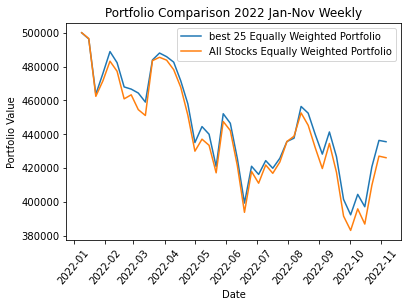

In [35]:
plt.plot(equally_weighted.index, equally_weighted['Portfolio'], label = 'best 25 Equally Weighted Portfolio')
plt.plot(all_equally_weighted.index, all_equally_weighted['Portfolio'], label = 'All Stocks Equally Weighted Portfolio')

#create appropriate titles and label
plt.title('Portfolio Comparison 2022 Jan-Nov Weekly')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')

# Rotate x-axes by 50 degrees
plt.xticks(rotation=50)

#plot legend
plt.legend()

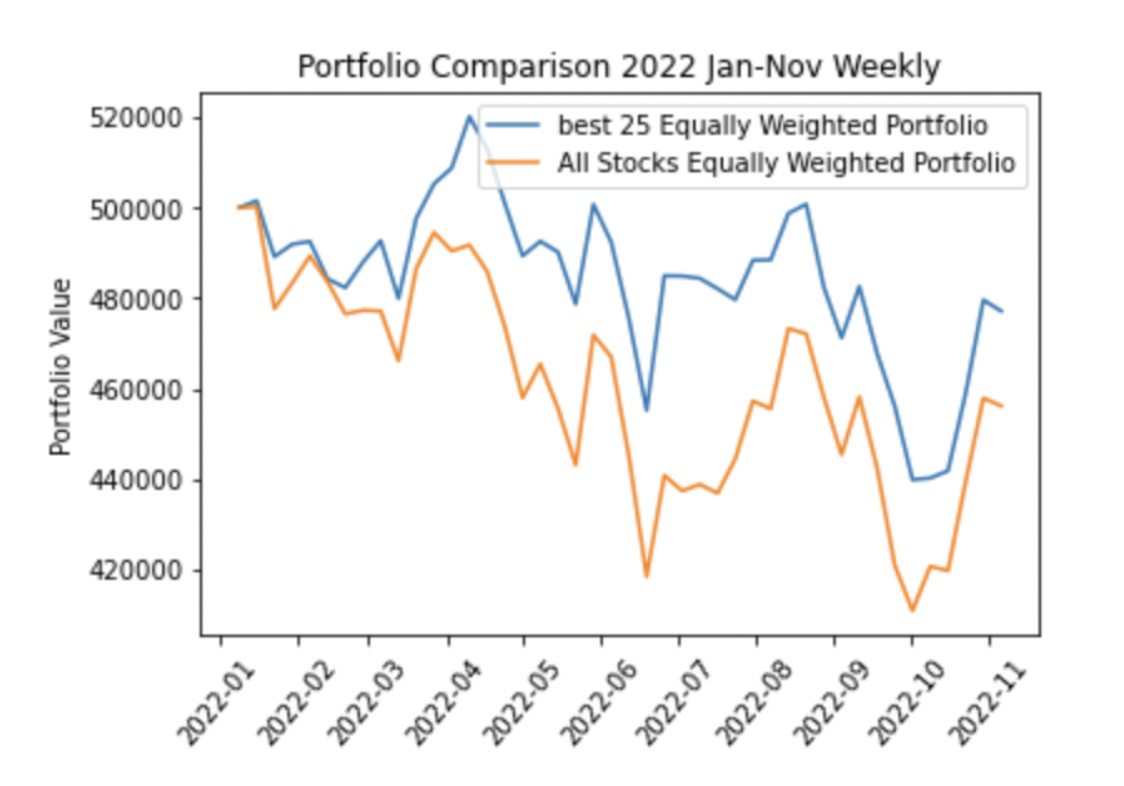

The graph above compares the total portfolio value with the top 25 stocks equally weighted versus the total portfolio value with all the stocks equally weighted from January to November 2022, if the csv file “Tickers_Example” was used to run our code. The top 25 stocks were determined using the same strategy to determine the safest portfolio.  Although both portfolio values follow a similar trend, the portfolio value with the top 25 stocks that are weighted equally fluctuates closer to the starting portfolio value of 500,000 dollars than the other portfolio. This is because the portfolio with all the stocks contains stocks that have high beta and standard deviation values which contributes to a riskier portfolio with more volatile stocks. This also suggests that the portfolio that experiences less fluctuation in total value is the safer portfolio as it contains the stocks with the lowest beta and standard deviation values out of all the stocks in the original csv file. Additionally, the difference between the starting portfolio value and ending portfolio value for the portfolio with 25 stocks is much less than the difference for the portfolio with all the stocks. 


In [36]:
#function consumes an indicator and graphs a scatter plot for both final portfolio and not final portfolio's ticker's indicator
def graph_stat (str_indicator):
    plt.scatter(ticker_stats['ticker'], ticker_stats[str_indicator], label=('tickers not in final portfolio'))
    plt.scatter(final_stats['ticker'], final_stats[str_indicator], label=('tickers in final portfolio'))

    #create appropriate titles and label
    plt.title(str_indicator + ' of tickers')
    plt.xlabel('Ticker')
    plt.ylabel(str_indicator)

    plt.axhline(y=final_stats[str_indicator].mean(), linestyle = "-", color = 'tab:orange')
    plt.axhline(y=ticker_stats[str_indicator].mean(), linestyle = "-", color = 'b')

    # Rotate x-axes by 50 degrees
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', which='major', labelsize=7)
    plt.legend()
    plt.show()


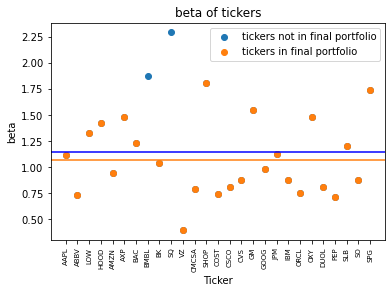

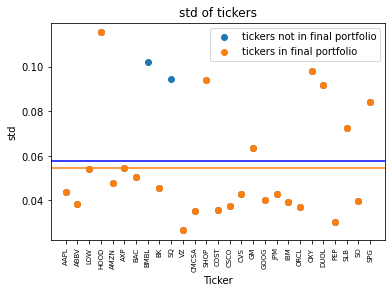

In [37]:
graph_stat('beta')
graph_stat('std')


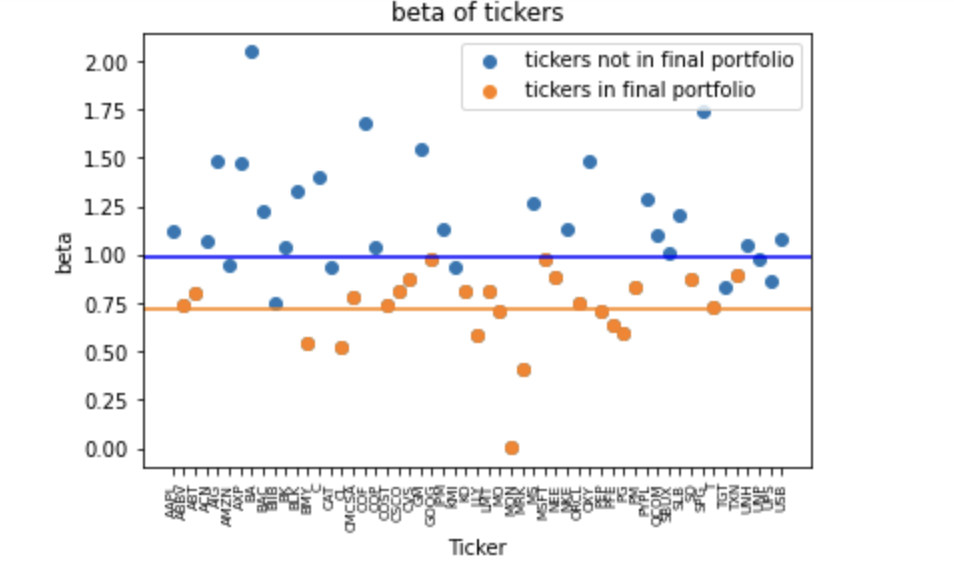


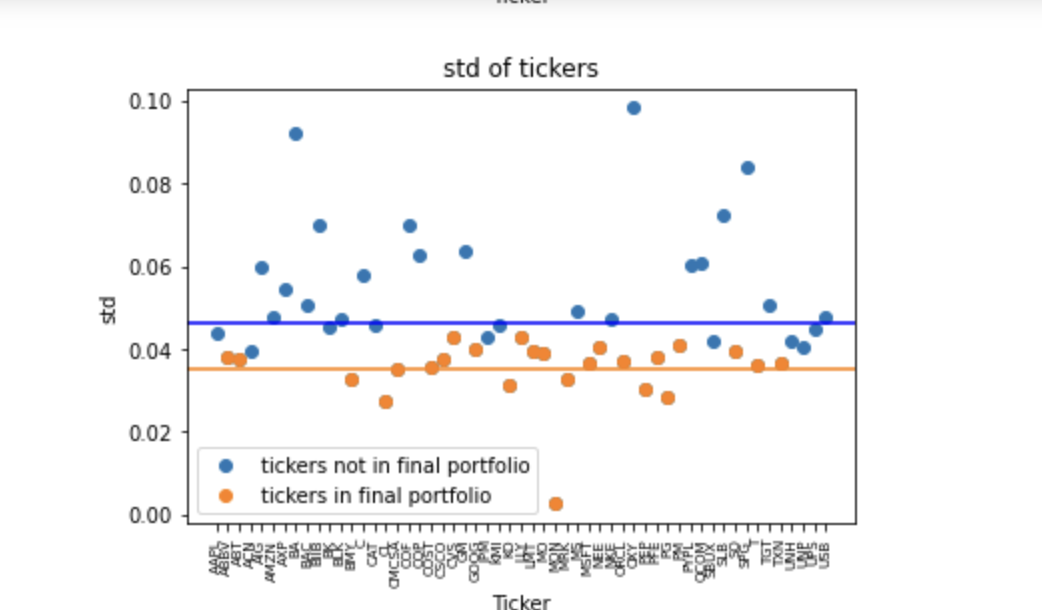




The above graphs show a clear distribution of the standard deviation and beta for the individual stocks of the portfolio created after the ranking system as well as before the ranking system. 

For the beta values of the tickers, you can see that the average, indicated by the blue line is around 1, which means that the stocks in the original portfolio's average flucutates very closely with the US market (S&P 500). Meanwhile all stocks chosen for the final portfolio, highlighted with orange, is below 1, with an average close to 0.75, which means it fluctuautes less than the market fluctuation, and also lower even after taking consideration for both standard deviation and beta.

Similarly the standard deviation is also lower than the average of the original portfolio, where we can see that the standard deviationi is less than 0.04, meaning the rate of return has standard deviation less than 4%. This will be able to guarantee that our final generated portfolio will not have extreme fluctuations. 

## Final Discussion

In summary, the three measures we used to build our safe portfolio with the maximum number of stocks possible are **beta**, which is a measurement of systematic risk, **standard deviation**, which is a measurement of the total risk of our portfolio’s expected return, and **correlation**, which is a measurement of how closely the returns of each security are related to each other. Although these three measures can provide us with a good indication of our total portfolio risk, there are some **limitations** to each of these methods of determining portfolio risk. For instance, beta is calculated based on historical data, so it is harder to predict how a stock will perform in the future since volatile stocks can fluctuate significantly over the years. However, these three measures of risk are more effective when used together to determine the safest portfolio that can be generated from the list of tickers given. 



### Step 7: Generate Final Portfolio
Based on the optimal weightings calculated in the step 6, we were able to generate our final portfolio as a dataframe called “Portfolio_Final” which contains the tickers, prices, number of shares, total value, and weightings. 


In [38]:
# Generate the Portfolio_Final dataframe from the average
Portfolio_Final = average[['Ticker', 'Shares', 'Value', 'Weight']]

# Readjust the index of the dataframe
Portfolio_Final = Portfolio_Final.reset_index(drop=True)
Portfolio_Final.index = np.arange(1, len(Portfolio_Final) + 1)

# print the dataframe Portfolio_final
Portfolio_Final

,Ticker,Shares,Value,Weight
1,VZ,600.069341,23414.705963,0.046829
2,PEP,103.281405,19015.139582,0.038030
3,COST,38.871733,20744.287751,0.041489
4,CMCSA,530.185305,18901.106915,0.037802
5,ABBV,131.858647,21047.276548,0.042095
6,ORCL,243.226771,20119.718828,0.040239
7,CSCO,387.169380,18738.998581,0.037478
8,SO,293.317272,19625.859715,0.039252
9,IBM,122.940093,18240.620990,0.036481
10,CVS,193.807414,19624.939196,0.039250


In [39]:
#print and round to three decimal places
print('The total portfolio weighting adds to: '+ str(round((Portfolio_Final.Weight.sum()*100),3)) + '%')
print('The total value of the portfolio is : $' + str((round((Portfolio_Final.Value.sum()),3))))

The total portfolio weighting adds to: 100.0%
The total value of the portfolio is : $500000.0


In [40]:
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.index = np.arange(1, len(Stocks_Final) + 1)
Stocks_Final

,Ticker,Shares
1,VZ,600.069341
2,PEP,103.281405
3,COST,38.871733
4,CMCSA,530.185305
5,ABBV,131.858647
6,ORCL,243.226771
7,CSCO,387.169380
8,SO,293.317272
9,IBM,122.940093
10,CVS,193.807414


In [41]:
Stocks_Final.to_csv('Stocks_Group_04.csv')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

James, Cherry, Cloris


**What We Changed:**
<font color=red>
    <br>
Originally, we had a function “filter_volume_currency” that filtered the list of tickers based on volume and currency requirements, but it ran into errors. So instead of filtering through volume and currency at same time, we divided our original code into two separate functions and made a few other changes. The first is “filter_currency” which filters for the currency of each ticker in the list. We added try and except in this function so that all errors related to currency could be caught. The second function we created is “filter_volume” which filters for the average volume of each ticker in the list and also uses try and except to catch those tickers without enough information for the dates required. 